# Classifying Names with Character-Level RNN

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## PART 1 Preparing the data

In [1]:
from __future__ import unicode_literals, print_function, division
import glob
import os
from io import open

findFiles = lambda path: glob.glob(path)

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


def unicodeToAscii(s):
    """
    Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
    :param s:
    :return:
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [2]:
# 构建类别词典，每种语言的姓名列表
category_lines = {}
all_categories = []


def readLines(filename):
    """
    读取文件的所有行
    :param filename:
    :return:
    """
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


# 解析语言文件
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

将 name 转换成 Tensor 以便使用它们
我们使用one-hot 表示单个字母
应次一个word 将字母连接成一个2D-matrix <line_length * 1 * n_letters>
额外的1 dim 因为 PyTorch 认为 everything in batches，这里我们使用 a batch size of 1

In [3]:
import torch


def letterToIndex(letter):
    """
    返回字母的位置
    :param letter:
    :return:
    """
    return all_letters.find(letter)


def letterToTensor(letter):
    """
    将字母转为 Tensor
    :param letter:
    :return:
    """
    tensor = torch.zeros(1, n_letters)  # (1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


def lineToTensor(line):
    """
    将 line(name) 转为 Tensor
    :param line:
    :return:
    """
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


#
print(findFiles('data/names/*.txt'))

print(all_letters, n_letters, sep='\n')

print(unicodeToAscii('Ślusàrski'))

print(f'一共有{n_categories}中语言')
print(category_lines['Italian'][:5])

print(letterToIndex('J'))
print(lineToTensor('Jone').size())

['data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/Arabic.txt', 'data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/German.txt', 'data/names/Dutch.txt', 'data/names/Russian.txt', 'data/names/Vietnamese.txt', 'data/names/English.txt', 'data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt', 'data/names/Chinese.txt', 'data/names/Greek.txt', 'data/names/French.txt']
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57
Slusarski
一共有18中语言
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
35
torch.Size([4, 1, 57])


## PART 2 Create the network

In [4]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

为了运行这个网络，我们需要传入一个输入(当前的字符 Tensor)和之前的隐藏状态(hidden state)
我们将得到输出(每个语言的概率)和下一个隐藏状态(hidden state)

In [5]:
"""
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9214, -2.8852, -2.8908, -2.9397, -2.9185, -2.9034, -2.9093, -2.8364,
         -2.9467, -2.8260, -2.8918, -2.8840, -2.7911, -2.8814, -2.9051, -2.8676,
         -2.9429, -2.8997]], grad_fn=<LogSoftmaxBackward>)
"""
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8609, -2.8435, -2.8864, -2.8497, -2.9412, -2.8367, -2.7834, -2.9586,
         -2.9122, -2.9147, -2.9696, -2.9753, -2.8825, -2.8510, -2.8286, -2.9300,
         -2.8829, -2.9449]], grad_fn=<LogSoftmaxBackward>)


## PART 3 Training

### Preparing for Training

In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


print(categoryFromOutput(output))

('Dutch', 6)


a quick way to get a training example (a name and its language):

In [7]:
import random


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f'category = {category}  / line = {line}')

category = Arabic  / line = Nassar
category = Greek  / line = Vlahos
category = Irish  / line = Simon
category = Italian  / line = Montagna
category = French  / line = Bordelon
category = Italian  / line = Cremonesi
category = Arabic  / line = Fakhoury
category = Scottish  / line = Christie
category = Spanish  / line = Arechavaleta
category = Italian  / line = Di caprio


### Train the network

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.



每次训练循环将要执行：
1. 创建 输入和目标 Tensor
2. 创建 初始值为0的 hidden state
3. 读取每个字母和传输 hidden state 给下一个字母
4. 比较输出(output)和 目标 (target)
5. 反向传播
6. 返回输出和损失

In [8]:
criterion = nn.NLLLoss()
learning_rate = 0.005  # If you set this too high, it might explode. If too low, it might not learn


def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [9]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
start = time.time()

for epoch in range(1, n_epochs + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if epoch % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print(
            '%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, timeSince(start), loss, line, guess, correct))

    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 20s) 2.5183 Vicario / Portuguese ✗ (Italian)
10000 10% (0m 37s) 2.2000 Ferreira / Portuguese ✓
15000 15% (0m 53s) 2.2557 Dalen / Irish ✗ (Dutch)
20000 20% (1m 12s) 1.0678 Wexler / German ✓
25000 25% (1m 28s) 2.1711 Allum / Scottish ✗ (English)
30000 30% (1m 40s) 1.7778 Gaber / German ✗ (Arabic)
35000 35% (1m 56s) 2.1646 Osman / Irish ✗ (English)
40000 40% (2m 12s) 4.1814 Pan / Vietnamese ✗ (French)
45000 45% (2m 28s) 2.1799 Owen / Dutch ✗ (English)
50000 50% (2m 39s) 0.9620 Basurto / Portuguese ✓
55000 55% (2m 55s) 4.2410 Hadash / Arabic ✗ (Czech)
60000 60% (3m 12s) 1.1382 Planick / Czech ✓
65000 65% (3m 23s) 0.4190 De santigo / Portuguese ✓
70000 70% (3m 34s) 0.2209 Bach / Vietnamese ✓
75000 75% (3m 50s) 0.2235 Cloutier / French ✓
80000 80% (4m 6s) 1.4030 Dagher / Arabic ✓
85000 85% (4m 17s) 0.5764 Chu / Vietnamese ✓
90000 90% (4m 33s) 3.7367 Jones / Dutch ✗ (Scottish)
95000 95% (4m 45s) 0.1023 Molchanov / Russian ✓
100000 100% (4m 56s) 2.3478 Nascimbene / German ✗ (Italia

### Plotting the Result

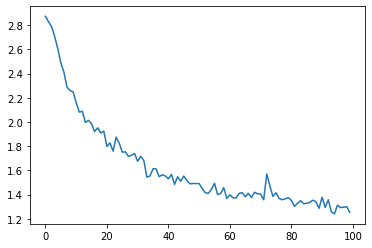

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## PART 4 Evaluating the Results

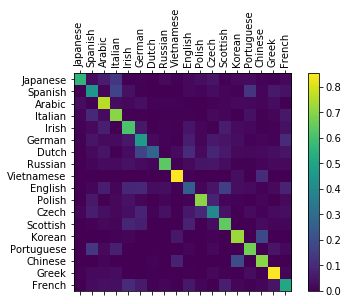

In [12]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output


for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 通过除以每一个行和 标准化
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 设置 Plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 设置 axes

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [13]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.66) Russian
(-1.08) Czech
(-2.32) Polish

> Jackson
(-0.05) Scottish
(-3.87) English
(-4.59) Czech

> Satoshi
(-0.97) Italian
(-1.33) Arabic
(-2.24) Japanese
